In [3]:
from Bio import SeqIO
import numpy as np
from pathlib import Path
import pandas as pd
import warnings
import os
from tools import read_fasta,supple_X
import gensim
import gzip
import os
import glob
import csv
import multiprocessing
Path('./data/Process_data/train/').mkdir(exist_ok=True, parents=True)
Path('./data/Process_data/test/').mkdir(exist_ok=True, parents=True)
Path('./word2vec_model/').mkdir(exist_ok=True, parents=True)

In [2]:
lab = ['Pos_train','Pos_test','Neg_train','Neg_test']
for f in lab:
    inpath_dir = 'data/'+'{}.txt'.format(f)
    outpath_dir = 'data/'+'Process_data/'+'{}.txt'.format(f)
    supple_X(inpath_dir,outpath_dir,100)

In [1]:
#设置参数
word2vec_modell = 'NPs'
Embsize = 100
stride = 1
Embepochs = 50
kmer_len3 = 3
kmer_len4 = 4
kmer_len5 = 5
kmer_len6 = 6
#定义函数
def Gen_Words(sequences,kmer_len,s):
		out=[]

		for i in sequences:

				kmer_list=[]
				for j in range(0,(len(i)-kmer_len)+1,s):

							kmer_list.append(i[j:j+kmer_len])

				out.append(kmer_list)

		return out
def read_fasta_file(Filename):
    '''
    used for load fasta data and transformd into numpy.array format
    '''
    fh = open(Filename, 'r')
    seq = []
    for line in fh:
        if line.startswith('>'):
            continue
        else:
            seq.append(line.replace('\n', '').replace('\r', ''))
    fh.close()
    matrix_data = np.array([list(e) for e in seq])
    #print(matrix_data)
    return seq

def train(sequences,kmer_len):
	print('training word2vec modell')
	document= Gen_Words(sequences,kmer_len,stride)
	#print(document)
	modell = gensim.models.Word2Vec (document, window=int(6), min_count=0, vector_size=Embsize,workers=multiprocessing.cpu_count())
	modell.train(document,total_examples=len(document),epochs=Embepochs)
	modell.save('word2vec_model'+'/'+word2vec_modell+str(kmer_len))
	return document

In [3]:
#训练word2vec并保存模型
all_seq = read_fasta_file('data/Process_data/all_data.txt')
document3 = train(all_seq,kmer_len3)
document4 = train(all_seq,kmer_len4)
document5 = train(all_seq,kmer_len5)
document6 = train(all_seq,kmer_len6)

training word2vec modell
training word2vec modell
training word2vec modell
training word2vec modell


In [4]:
model3 = gensim.models.Word2Vec.load('word2vec_model'+'/'+word2vec_modell+str(kmer_len3))
model4 = gensim.models.Word2Vec.load('word2vec_model'+'/'+word2vec_modell+str(kmer_len4))
model5 = gensim.models.Word2Vec.load('word2vec_model'+'/'+word2vec_modell+str(kmer_len5))
model6 = gensim.models.Word2Vec.load('word2vec_model'+'/'+word2vec_modell+str(kmer_len6))

In [5]:
#读取数据处理数据
#分别读取训练集和测试集
train_sets = {
    lab: read_fasta('data/Process_data/{:s}_train.txt'.format(lab))
    for lab in ['Pos','Neg']
}
test_sets = {
    lab: read_fasta('data/Process_data/{:s}_test.txt'.format(lab))
    for lab in ['Pos','Neg']
}
#定义标签
train_sets['Pos'].loc[:,'Label'] = 1
train_sets['Neg'].loc[:,'Label'] = 0
test_sets['Pos'].loc[:,'Label'] = 1
test_sets['Neg'].loc[:,'Label'] = 0

#确定编码以后的训练集和测试集
all_train = pd.concat([train_sets['Pos'],train_sets['Neg']],axis=0,ignore_index='ignore')
all_test = pd.concat([test_sets['Pos'],test_sets['Neg']],axis=0,ignore_index='ignore')
X_train = all_train.iloc[:,0:2]
X_test = all_test.iloc[:,0:2]
y_train = all_train['Label']
y_test = all_test['Label']
X_train.to_csv('data/Process_data/train/X_train.csv',index = False)
X_test.to_csv('data/Process_data/test/X_test.csv',index = False)
y_train.to_csv('data/Process_data/train/y_train.csv',index = False)
y_test.to_csv('data/Process_data/test/y_test.csv',index = False)

In [8]:
x_train = pd.read_csv('data/Process_data/train/X_train.csv')
x_train

,Id,Sequence
0,NP049871,SVQFKPRLXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...
1,NP056062,APLMGFQGVRXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...
2,NP032633,ALDGLDGAGFGFDXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...
3,NP035474,QYYYGASPYAYSGGYYDSPYSYXXXXXXXXXXXXXXXXXXXXXXXX...
4,NP006995,RVINDDCPNLIGNRDLYKRVEWICEDCSNIFRNTGMATLCRKNCFF...
...,...,...
3875,non-NeuroP0359751936,AAKLLLNPKFRCKAAFCXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...
3876,non-NeuroP0209341937,MDETIVTDKGVAEFSFFKFXXXXXXXXXXXXXXXXXXXXXXXXXXX...
3877,non-NeuroP0066251938,INWLKLGKMVIDALXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...
3878,non-NeuroP0074531939,MFEQTLTSDALVTTTHNHAAEPTQRPLRDSVQQALRNYLAQLNGQE...


In [6]:
#读取训练集测试集进行训练词向量
x_train1 = pd.read_csv('data/Process_data/train/X_train.csv')
x_train2 = x_train1['Sequence'].to_numpy()
x_train3 = Gen_Words(x_train2,kmer_len4,stride)
#将训练集通过word2vec--model3进行处理
X_train = []
for i in range(0,len(x_train3)):
    s = []
    for word in x_train3[i]:
        s.append(model4.wv[word])   
    X_train.append(s)
print(np.array(X_train).shape)

(3880, 97, 150)


In [6]:
#独立数据和Banch_data
x_test1 = pd.read_csv('data/Process_data/test/X_test.csv')
x_test2 = x_test1['Sequence'].to_numpy()
x_test3 = Gen_Words(x_test2,kmer_len4,stride)
X_test = []
for i in range(0,len(x_test3)):
    s = []
    for word in x_test3[i]:
        s.append(model4.wv[word])   
    X_test.append(s)
print(np.array(X_test).shape)


(970, 97, 100)


In [7]:
np.savez('data/Process_data/X_all4_100.npz', x_train=np.array(X_train),x_test = np.array(X_test))

In [45]:
data = pd.read_excel('results/整理.xlsx')
data

,Unnamed: 0,Id,Sequence,ourmodel,NeroPIpred,FUSE,FRL
0,0,NP00317,AGWSSLKGAW,0.995747,0.9696,0.960549,0.979
1,1,NP00717,DALSPPAAGLGADHSFT,0.947327,0.6052,0.519240,0.880
2,2,NP01482,DQNRNFLRF,0.999131,0.9932,0.984482,0.999
3,3,NP03336,DPYAFGLGKRPADLYEFGL,0.971610,0.9386,0.729304,0.613
4,4,NP02850,SSPCPPVEGPAGRQRPLCASRSRLIPAPRGAVLVQREKDLSTYNWN...,0.994511,0.9734,0.977131,0.968
...,...,...,...,...,...,...,...
965,965,non-NeuroP021909,MPVNNFGFLATLLFVAVPMLFLIGLYIQTNSNKS,0.000041,0.0193,0.029612,0.039
966,966,non-NeuroP015018,TETQSFNFNVFEPEN,0.867910,0.0923,0.039585,0.150
967,967,non-NeuroP010237,IFGAILPLALGALKNLIK,0.000957,0.0127,0.020218,0.101
968,968,non-NeuroP055262,GTQTNAPWGLARLIS,0.000254,0.1272,0.132024,0.161


In [46]:
y_our = data['ourmodel'].to_numpy()
y_Ipred = data['NeroPIpred'].to_numpy()
y_FUSE = data['FUSE'].to_numpy()
y_FRL = data['FRL'].to_numpy()

In [47]:
y_true = pd.read_csv('data/Process_data/test/y_test.csv').to_numpy()

In [53]:
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, confusion_matrix,precision_recall_curve, roc_curve, auc, fbeta_score,roc_auc_score
import pandas as pd
from tensorflow.keras.utils import to_categorical as labelEncoding 
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, confusion_matrix,precision_recall_curve, roc_curve, auc, fbeta_score,roc_auc_score

In [57]:
def multi_models_roc(names, colors, Y_1, y_2, save=True, dpin=600):
        """
        将多个机器模型的roc图输出到一张图上
        
        Args:
            names: list, 多个模型的名称
            sampling_methods: list, 多个模型的实例化对象
            save: 选择是否将结果保存（默认为png格式）
            
        Returns:
            返回图片对象plt
        """
#         sns.set()
        plt.figure(figsize=(8, 8))
        plt.grid(False)

        for (name, colorname,y_1) in zip(names, colors,Y_1):
            
#             method.fit(X_train, y_train)
            Yactual = y_2
#             Yp = method.predict(X_test)
            v = y_1
#             Yp = Yp.argmax(axis=1)
            fpr, tpr, _ = roc_curve(Yactual, v)
#             y_test_predprob = method.predict_proba(X_test)[:,1]
#             precision, recall, _ = precision_recall_curve(y_test, y_test_predprob)
#             fpr, tpr, thresholds = roc_curve(y_test, y_test_predprob, pos_label=1)
            
            plt.plot(fpr, tpr, lw=3, label='{} (AUC={:.3f})'.format(name, auc(fpr, tpr)),color = colorname)
            plt.plot([-0.01, 1.01], [-0.01, 1.01], '--', lw=3, color = 'grey')
            plt.axis('square')
            plt.xlim([-0.01, 1.01])
            plt.ylim([-0.01, 1.01])
            plt.xlabel('False Positive Rate',fontdict={'family' : 'Times New Roman', 'size' : 16})
            plt.ylabel('True Positive Rate',fontdict={'family' : 'Times New Roman', 'size' : 16})
            plt.title('ROC Curve',fontdict={'family' : 'Times New Roman', 'size' : 20})
            plt.legend(loc='lower right',fontsize=10)

        if save:
            plt.savefig('multi_models_roc222.png',dpi=600)
            
        return plt

In [58]:
names = ['NeuroPpred-Fuse','NeuroPred-FRL','PredNeuroP','NeuroPred-CLQ',]
Y_1 = [y_FUSE,y_FRL,y_Ipred,y_our]
colors = ['steelblue',
          'orange',
#           'gold',
          'mediumseagreen', 
          'crimson',
#           'mediumpurple'  
         ]
# X_t = [X2_o,X2_e,X2_w]

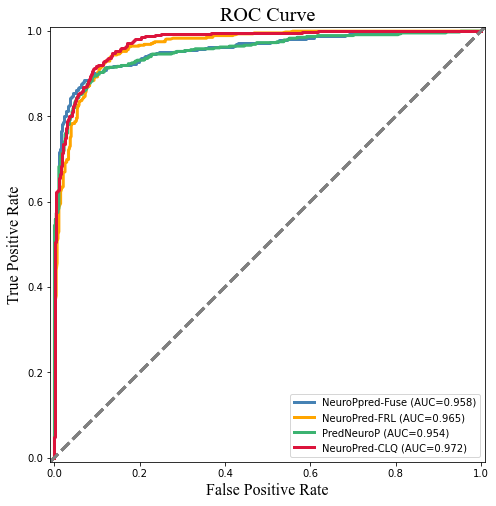

In [59]:
train_roc_graph = multi_models_roc(names,  colors, Y_1, y_true, save = True)